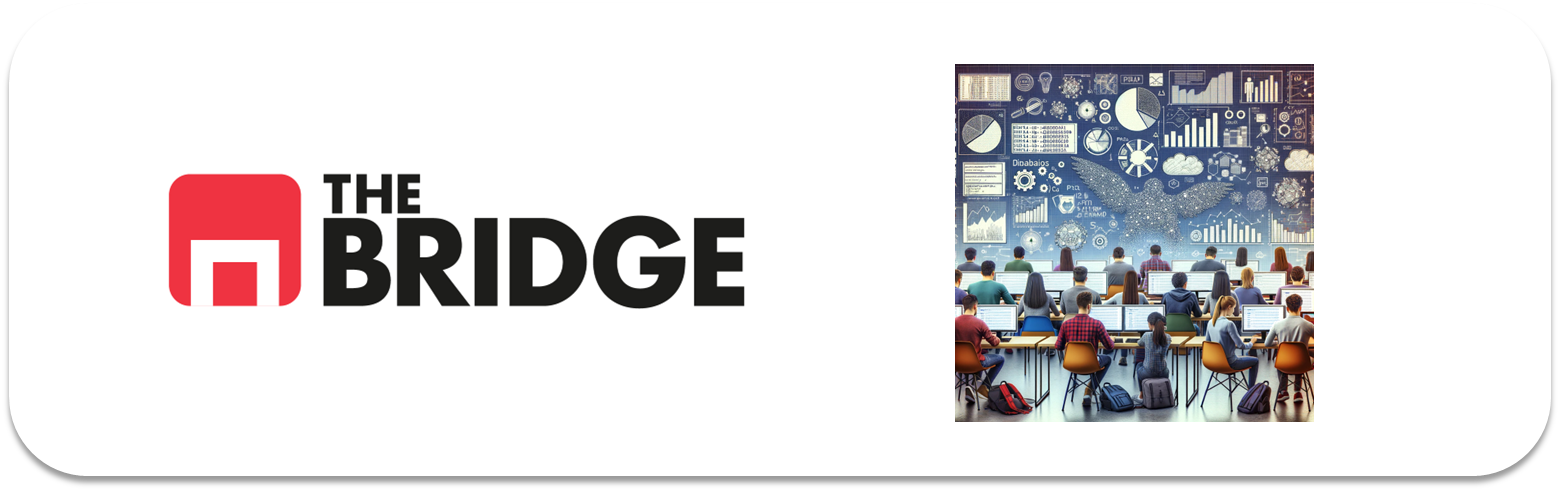

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en `modelar la supervivencia en el Titanic`, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import machinelearningtools as ml
import vizdatatools as viz

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



## 1. Cargar el dataset

In [2]:
df_titanic = pd.read_csv('./data/titanic.csv')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 2. Limpiar the dataset

In [3]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [4]:
df_titanic = pd.read_csv('./data/titanic.csv')

# Elimino columnas. Bien porque son redundantes o porque tienen demasiados valores missing 
# Por ejemplo, "adult_male" las elimino porque van intrinsecas en "sex" y "age". 
# "who" la usaré para imputar los missing de las edades
df_titanic.drop(columns=['embarked', 'class', 'adult_male', 'deck', 'alive', 'alone'], 
                inplace=True)

# Me quedo con el número de parientes de cada pasajero
df_titanic['family_members'] = df_titanic['parch'] + df_titanic['sibsp']
df_titanic.drop(columns=['parch', 'sibsp'], inplace=True)

# Elimino los dos elementos nulos de "embark_town" para que no den problema en el split de train y test
df_titanic.dropna(subset=['embark_town'], inplace=True)

df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   survived        889 non-null    int64  
 1   pclass          889 non-null    int64  
 2   sex             889 non-null    object 
 3   age             712 non-null    float64
 4   fare            889 non-null    float64
 5   who             889 non-null    object 
 6   embark_town     889 non-null    object 
 7   family_members  889 non-null    int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 62.5+ KB


## 3. Analizar de forma gráfica la variable *target* y su distribución para comprender su impacto

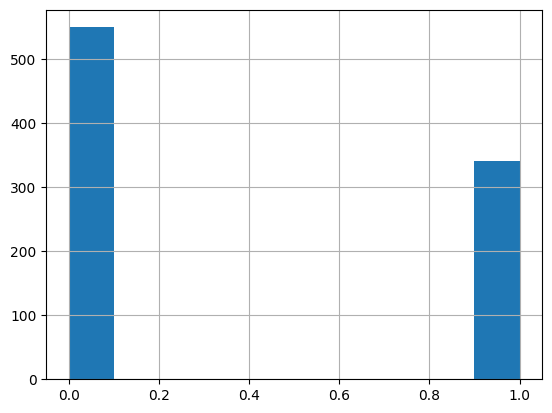

survived
0    549
1    340
Name: count, dtype: int64
survived
0    0.617548
1    0.382452
Name: proportion, dtype: float64


In [5]:
# target
df_titanic['survived'].hist()
plt.show()

# Distribución de supervivientes
print(df_titanic['survived'].value_counts())
print(df_titanic['survived'].value_counts(normalize=True))

## 4. Split en train y test, asegurando que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.

In [6]:
X = df_titanic.drop(columns=['survived']).copy()
y = df_titanic['survived'].copy()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, 
                                                    random_state=42, stratify=X['embark_town']) 

# Proporción de ciudades de embarque
print(X_train['embark_town'].value_counts(normalize=True))
print(X_test['embark_town'].value_counts(normalize=True))

embark_town
Southampton    0.724332
Cherbourg      0.188467
Queenstown     0.087201
Name: proportion, dtype: float64
embark_town
Southampton    0.724719
Cherbourg      0.191011
Queenstown     0.084270
Name: proportion, dtype: float64


## 5. Imputar los nulos con medias o modas en la X de train. Guardamos esas medias que se necesitarán en la parte de test.

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 711 entries, 46 to 253
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          711 non-null    int64  
 1   sex             711 non-null    object 
 2   age             573 non-null    float64
 3   fare            711 non-null    float64
 4   who             711 non-null    object 
 5   embark_town     711 non-null    object 
 6   family_members  711 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 44.4+ KB


In [8]:
# Marcar los valores que originalmente eran NaN
X_train['age_was_NaN'] = X_train['age'].isna() 

# Sustituir los valores NaN por la media de cada grupo (niños, mujeres, hombres)
is_man = X_train['who'] == 'man'
is_woman = X_train['who'] == 'woman'
is_child = X_train['who'] == 'child'

# Estos valores los imputaré en el set de "test"
man_mean_age = round(X_train.loc[is_man, 'age'].mean(), 1)
woman_mean_age = round(X_train.loc[is_woman, 'age'].mean(), 1)
child_mean_age = round(X_train.loc[is_child, 'age'].mean(), 1)

X_train.loc[is_man, 'age'] = X_train.loc[is_man, 'age'].fillna(man_mean_age)
X_train.loc[is_woman, 'age'] = X_train.loc[is_woman, 'age'].fillna(woman_mean_age)
X_train.loc[is_child, 'age'] = X_train.loc[is_child, 'age'].fillna(child_mean_age)


## 6. Mini-EDA, seleccionando las features que queremos quedarnos y por qué.


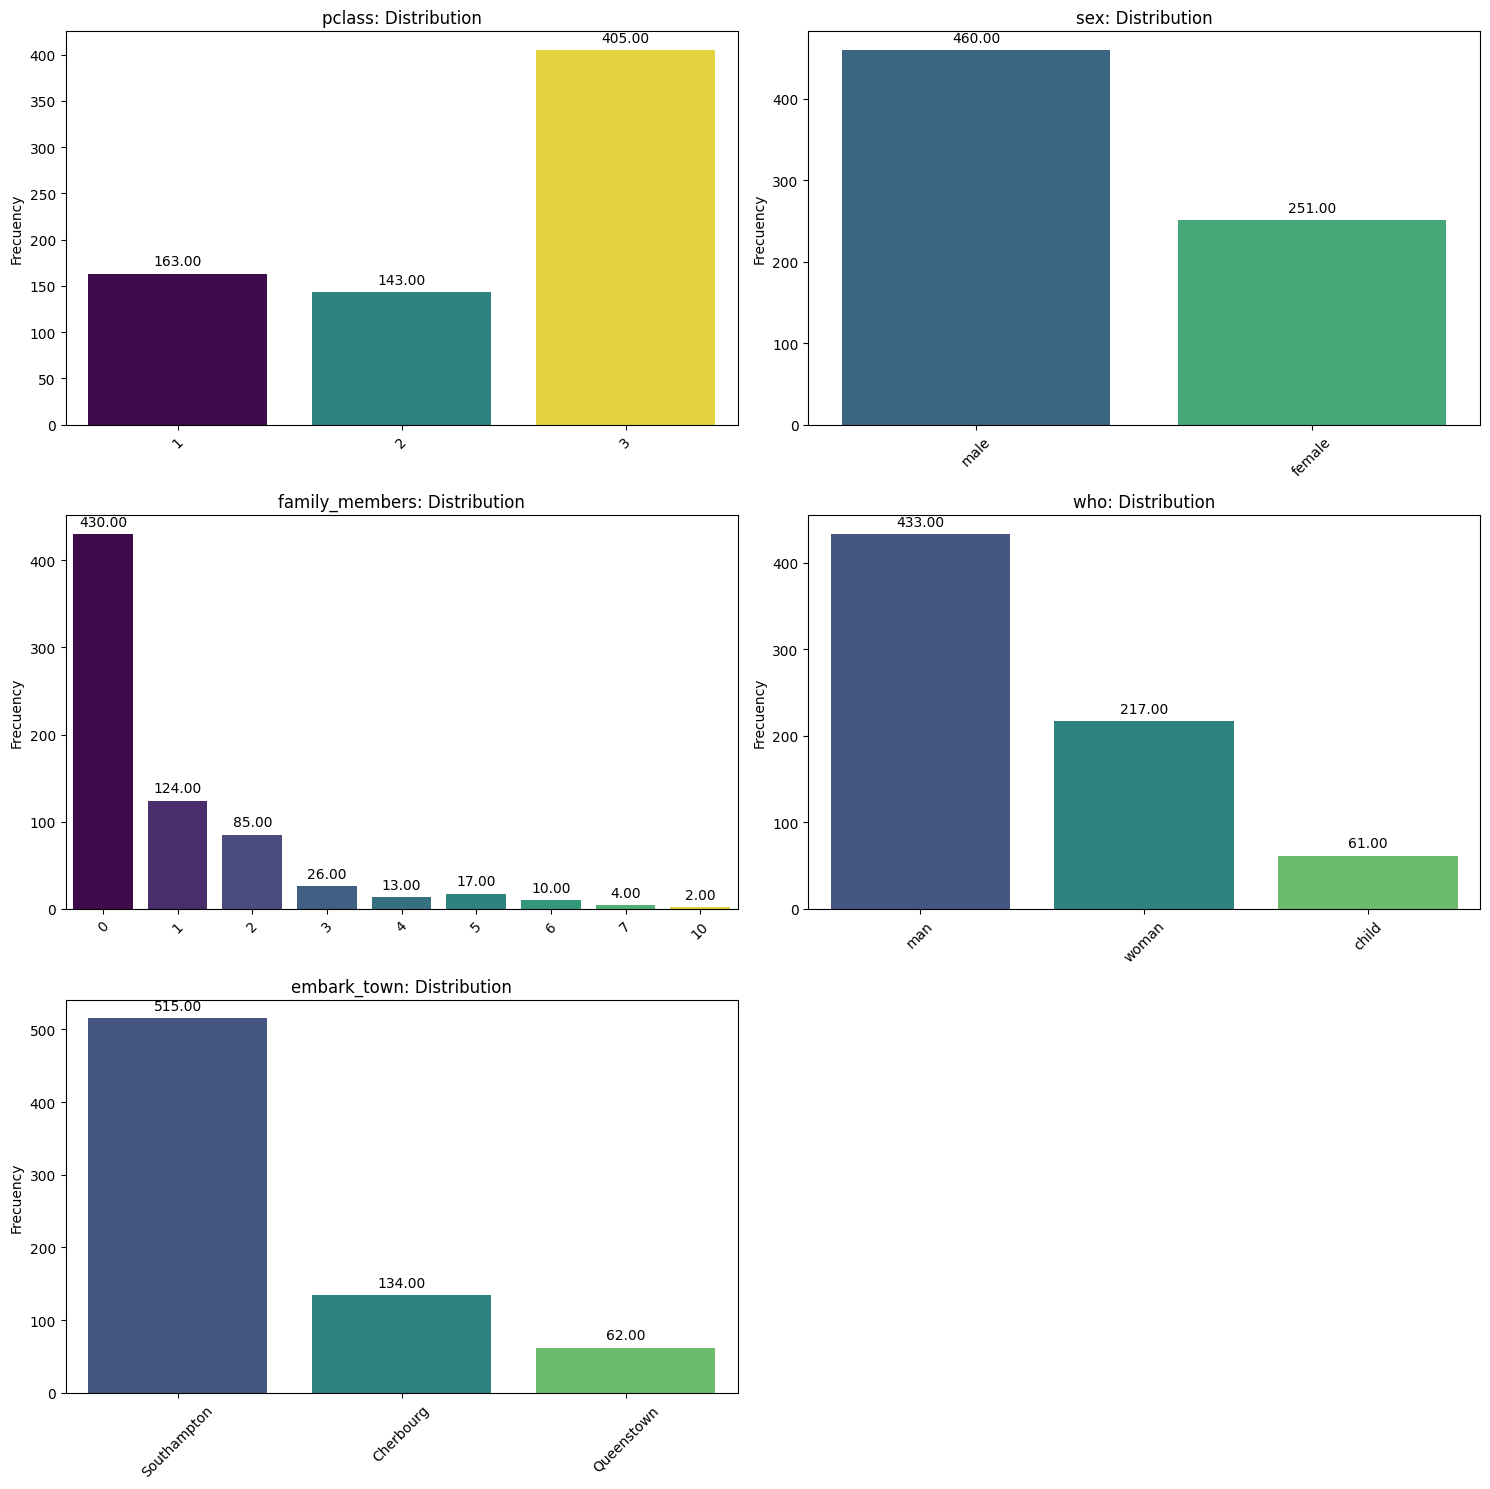

,pclass,age,fare,family_members
count,711.000000,711.000000,711.000000,711.000000
mean,2.340366,30.266231,31.646823,0.867792
std,0.827036,13.095862,51.212661,1.478281
min,1.000000,0.670000,0.000000,0.000000
25%,2.000000,22.000000,7.895800,0.000000
50%,3.000000,31.600000,14.000000,0.000000
75%,3.000000,35.000000,30.285400,1.000000
max,3.000000,80.000000,512.329200,10.000000


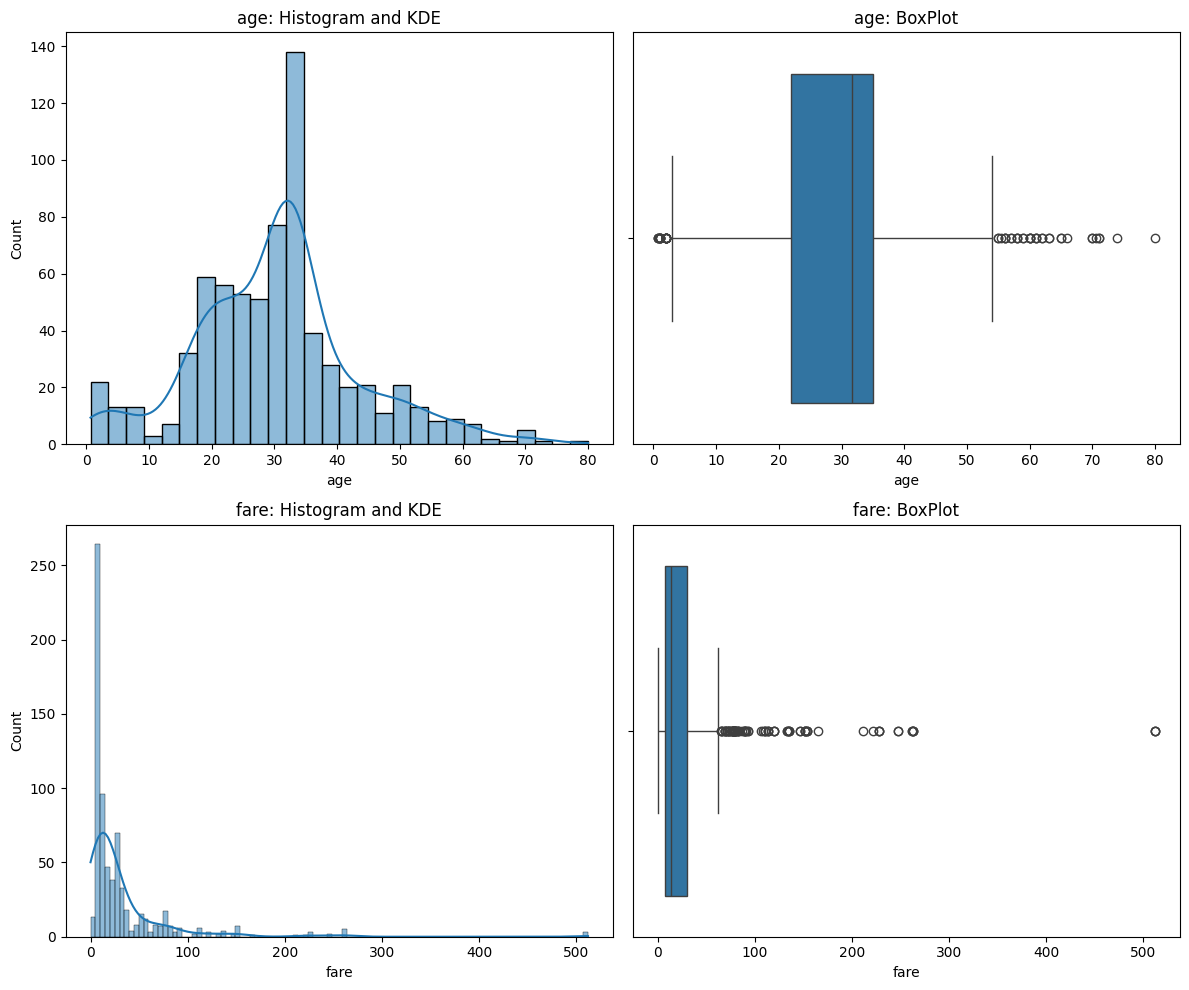

In [9]:
# Variables categoricas
categorical_columns=['pclass', 'sex', 'family_members', 'who', 'embark_town']
viz.plot_multiple_categorical_distributions(X_train, categorical_columns=categorical_columns)

# Tendencia
display(X_train.describe())

# Análisis gráfico. "pclass" y "family_members" aunque tienen representación 
# numérica (mejor para machine learning), son categóricas
col_numericas = ['age', 'fare']
viz.plot_multiple_histograms_KDEs_boxplots(X_train, col_numericas)

<Axes: >

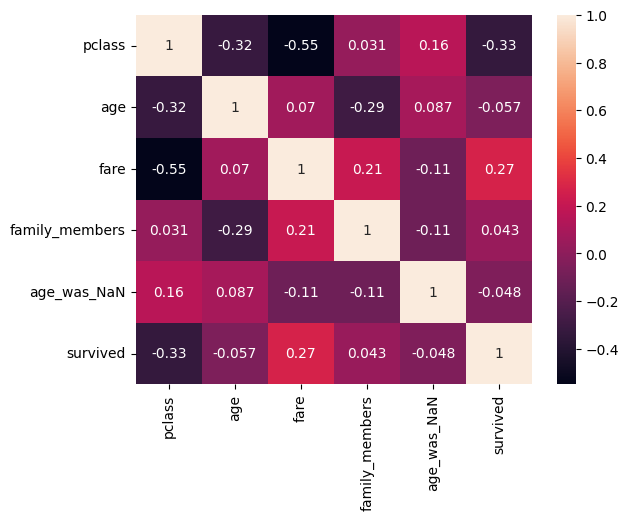

In [10]:
# Correlación de forma gráfica
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(numeric_only=True),
            annot=True)

In [11]:
X_train

,pclass,sex,age,fare,who,embark_town,family_members,age_was_NaN
46,3,male,33.0,15.500,man,Queenstown,1,True
230,1,female,35.0,83.475,woman,Southampton,1,False
657,3,female,32.0,15.500,woman,Queenstown,2,False
888,3,female,31.6,23.450,woman,Southampton,3,True
809,1,female,33.0,53.100,woman,Southampton,1,False
...,...,...,...,...,...,...,...,...
222,3,male,51.0,8.050,man,Southampton,0,False
167,3,female,45.0,27.900,woman,Southampton,5,False
123,2,female,32.5,13.000,woman,Southampton,0,False
150,2,male,51.0,12.525,man,Southampton,0,False


In [12]:
# Elimino "who" porque es redundante con "age" y "sex"; y "age_was_NaN" porque es interna
features = ['pclass', 'sex', 'age', 'fare', 'embark_town', 'family_members']
X_train = X_train[features]

Considero que las features más representativas para este proyecto son:

features = ['pclass', 'sex', 'age', 'fare', 'embark_town', 'family_members']

## 7 Tratar las variables para que funcionen lo mejor posible en el modelo.

Las variables "sex" y "embark_town" son categoricas pero no parecen tener ningún orden de importancia, sumado a que hay pocas variables, parece acertado hacer un *One-Hot Encoding*.

La variable "fare" está muy desbalanceada, podría aplicar el logaritmo pero me da un fallo de infinito.

Por otro lado, el escalado (Standardization) es más apropiado cuando los datos siguen una distribución normal (o aproximadamente normal).
Es especialmente útil para algoritmos como Regresión Lineal, Regresión Logística, SVM y Redes Neuronales, donde las características normalizadas mejoran la estabilidad numérica y el rendimiento del modelo.
Es crucial para modelos que asumen que los datos están centrados en torno a cero, como en las regresiones y los métodos de descenso de gradiente.

In [13]:
# One-Hot Encoding para las categóricas
X_train = pd.get_dummies(X_train, columns=['sex', 'embark_town'], dtype = int)

# Aplicación de logaritmo --> Me está dando fallos pero es útil? Si le sumo 1 me ahorro el fallo del log(0)
# X_train['fare'] = X_train['fare'].apply(np.log)

# Standard Scaler para las numéricas, pero debería hacerlo sobre 
std_scaler = StandardScaler()
X_train[['age', 'fare']] = std_scaler.fit_transform(X_train[['age', 'fare']])

In [14]:
X_train[['age', 'fare']] = std_scaler.fit_transform(X_train[['age', 'fare']])

## 8 Modelo de regresión logistica y analizar los pesos

[[-0.90634163 -0.37905939  0.19844697 -0.26087077  1.37442206 -1.37126141
   0.10244364  0.15619623 -0.25547922]]


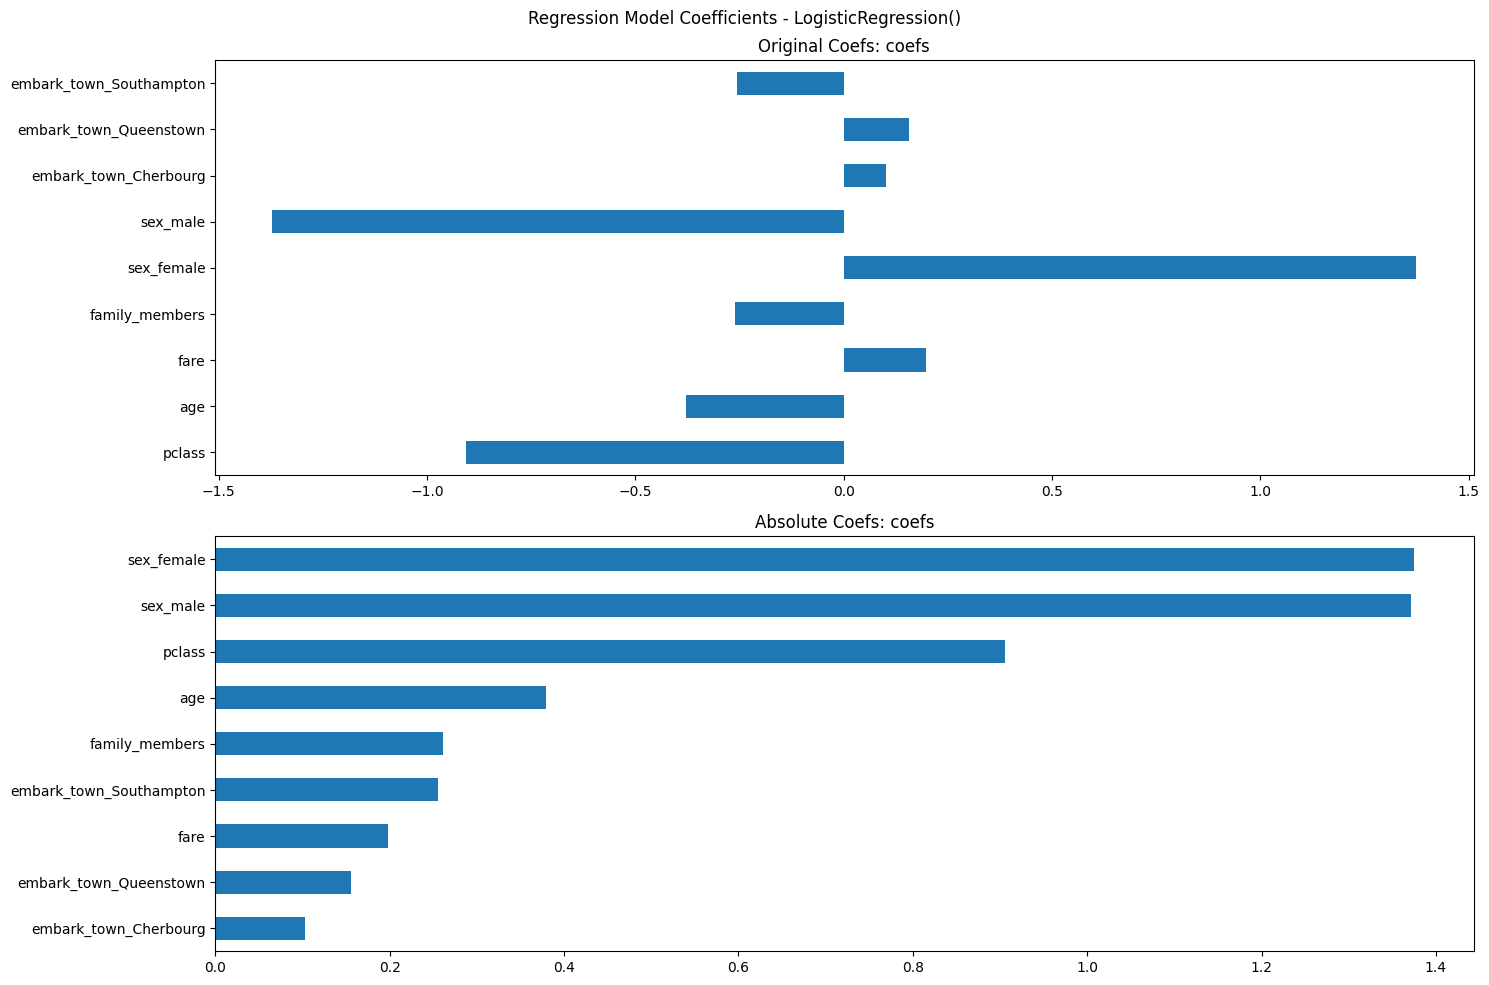

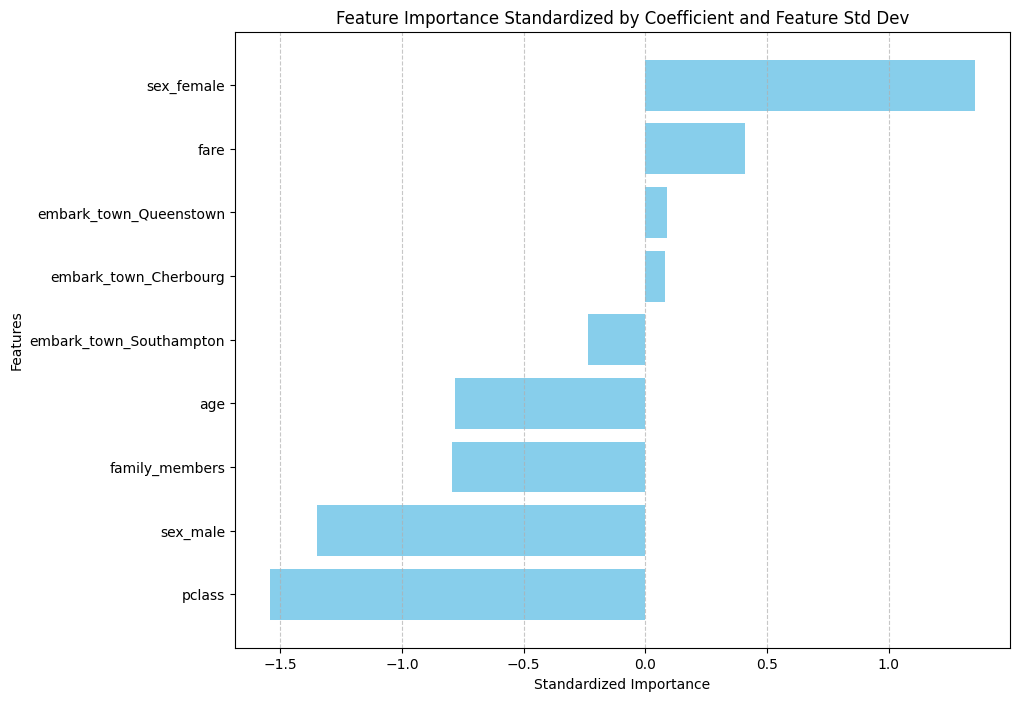

In [15]:
# Modelo de regresión logística
model_logR = LogisticRegression()

# Entrenar modelo
model_logR.fit(X_train, y_train)

# Importancia de los pesos
print(model_logR.coef_)
ml.show_regression_coefs(model_logR)
ml.plot_features_importance(model_logR, X_train, y_train)

## 9. Procesar el dataset de "Test" para que poder usarlo en la evaluación 

In [16]:
# X_test original
display(X_test.info())

# Sustituir los valores NaN por la media de cada grupo (niños, mujeres, hombres)
is_man = X_test['who'] == 'man'
is_woman = X_test['who'] == 'woman'
is_child = X_test['who'] == 'child'

# Imputando los valores anteriormente calculados
X_test.loc[is_man, 'age'] = X_test.loc[is_man, 'age'].fillna(man_mean_age)
X_test.loc[is_woman, 'age'] = X_test.loc[is_woman, 'age'].fillna(woman_mean_age)
X_test.loc[is_child, 'age'] = X_test.loc[is_child, 'age'].fillna(child_mean_age)

# Selección de features
X_test = X_test[features]

# One-Hot Encoding
X_test = pd.get_dummies(X_test, columns=['sex', 'embark_town'], dtype = int)

# Standard Scaler aplicado con el fit del train
X_test[['age', 'fare']] = std_scaler.transform(X_test[['age', 'fare']])

# X_test para el modelo
display(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 223 to 142
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pclass          178 non-null    int64  
 1   sex             178 non-null    object 
 2   age             139 non-null    float64
 3   fare            178 non-null    float64
 4   who             178 non-null    object 
 5   embark_town     178 non-null    object 
 6   family_members  178 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 11.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 223 to 142
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pclass                   178 non-null    int64  
 1   age                      178 non-null    float64
 2   fare                     178 non-null    float64
 3   family_members           178 non-null    int64  
 4   sex_female               178 non-null    int64  
 5   sex_male                 178 non-null    int64  
 6   embark_town_Cherbourg    178 non-null    int64  
 7   embark_town_Queenstown   178 non-null    int64  
 8   embark_town_Southampton  178 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 13.9 KB


None

## 10. Evaluar tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.

In [17]:
# Predicciones
pred_train = model_logR.predict(X_train)
pred_test = model_logR.predict(X_test)

In [18]:
# Accuracy. Lo voy a probar porque la distribución no está totalmente desbalanceada
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print("Accuracy train:", acc_train)
print("Accuracy test:", acc_test)

print(y_train.value_counts(True))
print(y_test.value_counts(True))

Accuracy train: 0.8115330520393812
Accuracy test: 0.7078651685393258
survived
0    0.618847
1    0.381153
Name: proportion, dtype: float64
survived
0    0.61236
1    0.38764
Name: proportion, dtype: float64


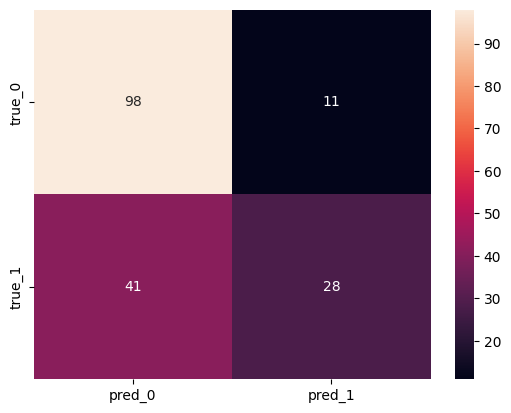

c:\Users\Lander\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


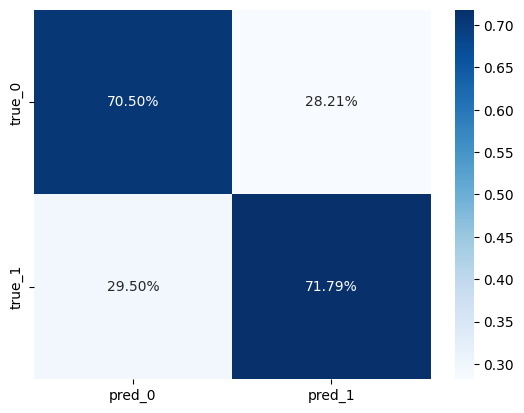

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       109
           1       0.72      0.41      0.52        69

    accuracy                           0.71       178
   macro avg       0.71      0.65      0.65       178
weighted avg       0.71      0.71      0.68       178



In [19]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, pred_test)
conf_matrix_df = pd.DataFrame(conf_matrix, columns = ['pred_0', 'pred_1'],
                          index = ['true_0', 'true_1'])

# Dibujar con seaborn
sns.heatmap(conf_matrix_df, annot=True, fmt='g');
plt.show()

# Otra representación (porcentual)
sns.heatmap(conf_matrix_df/np.sum(conf_matrix_df), annot=True, 
            fmt='.2%', cmap='Blues');
plt.show()

# Classification_report Es una métrica que nos va a decir por clase su precisión y su recall.
print(classification_report(y_test, pred_test))

AUC: 0.77


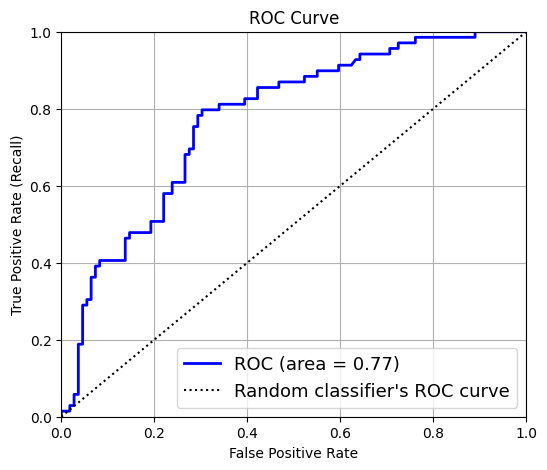

In [20]:
# ROC Curve
ml.plot_roc_curve(model_logR, X_test, y_test)

Considero que tengo un buen modelo de clasificación, con unas estadísticas bastante positivas.

## 11. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.

Importante, que sobre el nuevo elemento para la predicción hay que hacer todas las transformaciones numéricas que hemos hecho en train y en test. En este caso solo el `standard scaler` sobre "age" y "fare"


In [42]:
# Voy a recordar la estructura de mis datos
X_test.columns


Index(['pclass', 'age', 'fare', 'family_members', 'sex_female', 'sex_male',
       'embark_town_Cherbourg', 'embark_town_Queenstown',
       'embark_town_Southampton'],
      dtype='object')

In [41]:
#Lista para almacenar las probabilidades
prob_perecer = []
prob_sobrevivir = []

for age in range(30, 41):
    # Define el diccionario de características para el pasajero y lo convierto en DataFrame
    new_passenger = {
        'pclass': 2,
        'age': age,
        'fare': 0,
        'family_members': 0,
        'sex_female': 0,
        'sex_male': 1,
        'embark_town_Cherbourg': 0,
        'embark_town_Queenstown': 0,
        'embark_town_Southampton': 1
        }
    new_passenger = pd.DataFrame([new_passenger])

    # Standard Scaler aplicado con el fit del train
    new_passenger[['age', 'fare']] = std_scaler.transform(new_passenger[['age', 'fare']])
    
    # Calcula la probabilidad de supervivencia usando el modelo   
    prob_perecer.append(model_logR.predict_proba(new_passenger)[0][0])
    prob_sobrevivir.append(model_logR.predict_proba(new_passenger)[0][1])

print(f"La media de la probabilidad de perecer es: {100 * np.mean(prob_perecer):.2f}")
print(f"La media de la probabilidad de supervivencia es: {100 * np.mean(prob_sobrevivir):.2f}")


La media de la probabilidad de perecer es: 100.00
La media de la probabilidad de supervivencia es: 0.00


## 12. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  

NO entiendo muy bien lo que se pide en este apartado. Lo evaluo de forma similar a la anterior.

In [45]:
#Lista para almacenar las probabilidades
prob_perecer = []
prob_sobrevivir = []

for age in range(30, 41):
    # Define el diccionario de características para el pasajero y lo convierto en DataFrame
    new_passenger = {
        'pclass': 1,
        'age': age,
        'fare': 0,
        'family_members': 0,
        'sex_female': 0,
        'sex_male': 1,
        'embark_town_Cherbourg': 0,
        'embark_town_Queenstown': 0,
        'embark_town_Southampton': 1
        }
    new_passenger = pd.DataFrame([new_passenger])

    # Standard Scaler aplicado con el fit del train
    new_passenger[['age', 'fare']] = std_scaler.transform(new_passenger[['age', 'fare']])
    
    # Calcula la probabilidad de supervivencia usando el modelo   
    prob_perecer.append(model_logR.predict_proba(new_passenger)[0][0])
    prob_sobrevivir.append(model_logR.predict_proba(new_passenger)[0][1])

print(f"La media de la probabilidad de perecer es: {100 * np.mean(prob_perecer):.2f}")
print(f"La media de la probabilidad de supervivencia es: {100 * np.mean(prob_sobrevivir):.2f}")


La media de la probabilidad de perecer es: 100.00
La media de la probabilidad de supervivencia es: 0.00
